In [3]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [4]:
# Model
model = torch.hub.load("ultralytics/yolov5", "yolov5n")  # or yolov5n - yolov5x6, custom

Using cache found in /home/emilianh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-9 Python-3.8.10 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [8]:
# Images
#img = "data/images/zidane.jpg" # or file, Path, PIL, OpenCV, numpy, list
imgPath = "images/foto_desktop.jpeg"
img = cv2.imread(imgPath)

In [9]:
results = model(img)

Predicted mouse at [775.89, 745.12, 904.52, 866.81, 0.78] with confidence 64.00.
Predicted laptop at [621.07, 339.6, 1034.99, 713.51, 0.74] with confidence 63.00.
Predicted keyboard at [3.67, 739.06, 754.64, 960.0, 0.63] with confidence 66.00.
Predicted tv at [0.0, 42.0, 640.61, 623.34, 0.42] with confidence 62.00.
Predicted mouse at [353.86, 679.54, 454.64, 751.22, 0.32] with confidence 64.00.


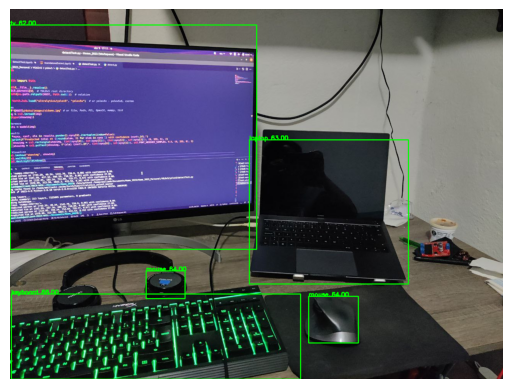

In [10]:
%matplotlib inline
# Results
showimg = img.copy()
for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
    print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
    showimg = cv2.rectangle(showimg, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
    showimg = cv2.putText(showimg, f"{cls} {conf:.2f}", (int(xyxy[0]), int(xyxy[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Visualize on matplotlib
plt.imshow(cv2.cvtColor(showimg, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [14]:
scale_percent = 20 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

predictor.set_image(resized)

In [19]:
object = "laptop"

for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
    if cls == object:
        print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
        input_box = np.array([xyxy[0], xyxy[1], xyxy[2], xyxy[3]])
        break

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

Predicted laptop at [621.07, 339.6, 1034.99, 713.51, 0.74] with confidence 63.00.


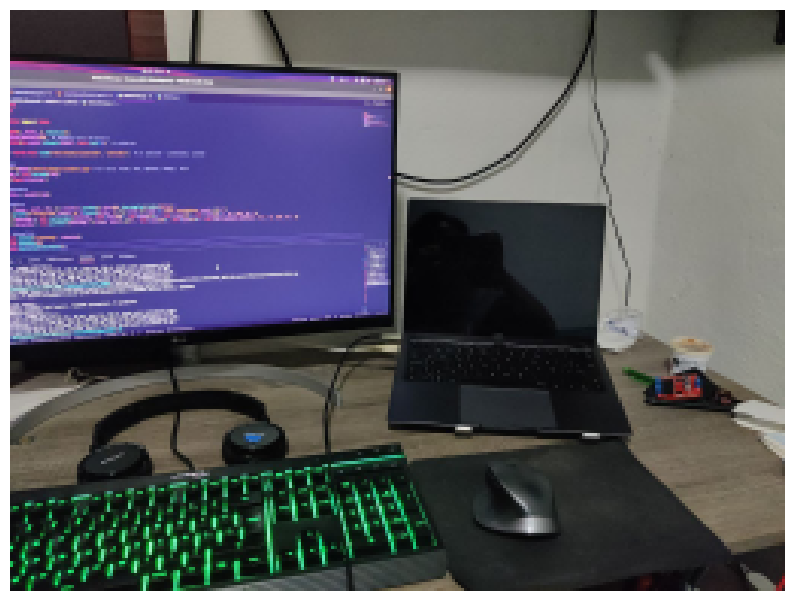

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
show_mask(masks[0], plt.gca())
plt.axis('off')
plt.show()